In [2]:
# import
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#load data and EDA
df = pd.read_csv('C:/Users/C973119/Downloads/VSC data/subscription records.csv')


In [4]:
# convert mixed format date string into datetime type
df['date'] = pd.to_datetime(df['date'], format='mixed')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date                 1048575 non-null  datetime64[ns]
 1   event_type           1048575 non-null  object        
 2   program_name         1048575 non-null  object        
 3   preference_added_by  1048575 non-null  object        
 4   channel              1048575 non-null  object        
 5   account              1040258 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 48.0+ MB
None


EDA

In [5]:
# counts by channel
df.groupby('channel')['account'].nunique()

channel
EMAIL     126807
PUSH      471227
SMS      1368669
VOICE      42209
Name: account, dtype: int64

In [7]:
# counts by program
df.groupby('brand')['account'].nunique()

brand
gerber     160758
kitkat     302501
nescafe    289012
Name: account, dtype: int64

In [12]:
# counts by opco
df.groupby(['brand', 'channel'])['account'].nunique()

brand    channel
gerber   EMAIL       12593
         PUSH        50123
         SMS        109708
         VOICE        3914
kitkat   EMAIL       11689
         PUSH        65614
         SMS        244845
         VOICE        4426
nescafe  EMAIL       22167
         PUSH        95053
         SMS        188887
         VOICE        6202
Name: account, dtype: int64

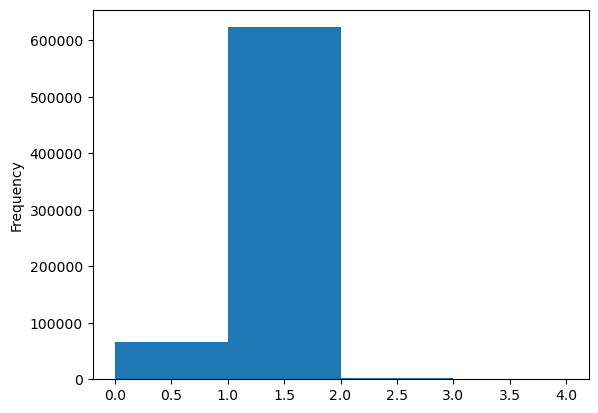

In [41]:
# counts of channel per customer
ccounts = df.groupby(['account', 'event_type'])['brand'].nunique()
ccounts = ccounts.unstack(level=-1)
ccounts = ccounts.fillna(0)
ccounts['net'] = ccounts['Initial'] + ccounts['INSERT'] - ccounts['DELETE']

ccounts['net'].plot(kind='hist', bins=[0,1,2,3,4])
plt.show()


In [22]:
# engineer month and year features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
print(df.head())

        date event_type preference_added_by channel       account    brand  \
0 2020-11-10     INSERT            REACHAPI     SMS  5.002460e+10   kitkat   
1 2020-11-10     INSERT            REACHAPI     SMS  5.002505e+10   kitkat   
2 2020-11-10     DELETE            REACHAPI     SMS  5.501131e+10   kitkat   
3 2020-11-10     INSERT            REACHAPI   EMAIL  5.500147e+10   gerber   
4 2020-11-10     INSERT            REACHAPI   EMAIL  5.002349e+10  nescafe   

   year  month  
0  2020     11  
1  2020     11  
2  2020     11  
3  2020     11  
4  2020     11  


All Brand Aggregation Analysis

In [23]:
# slice df to channel
sms = df[df.channel == 'SMS']
push = df[df.channel == 'PUSH']
email = df[df.channel == 'EMAIL']
voice = df[df.channel == 'VOICE']

In [24]:
# define function to perform unsubscription rate calculation
def unrate(df):
    ym = df.groupby(['year', 'month', 'event_type'])['account'].nunique()
    ym = ym.unstack(level=-1) #last level of index, here it's event_type

    # calculate cummulative
    ym['cumdel'] = ym['DELETE'].cumsum()
    ym['cumins'] = ym['INSERT'].cumsum()

    # lag a row to get beginning balance
    beg = ym.iloc[0,2]
    ym['endins'] = ym['cumins'] - ym['cumdel'] + beg
    ym['begins'] = ym['endins'].shift(1)

    ym['unrate'] = ym['DELETE'] / ym['begins'] * 100
    return ym

In [25]:
# calcualate unsubscription rate
ym_sms = unrate(sms)
ym_push = unrate(push)
ym_email = unrate(email)
ym_voice = unrate(voice)

In [35]:
# define a plot function
def complot(df):
    fig, ax1 = plt.subplots(figsize=(15,8))
    df.loc[2023]['endins'].plot(kind='bar', ax=ax1, color='#ff7f0e')
    plt.ylabel('subscription base')

    ax2=ax1.twinx()
    df.loc[2023]['unrate'].plot(kind='line', ax=ax2, color='#1f77b4')
    plt.ylabel('unsubscription rate %')
    
    return fig

Visuals of monthly unsubscription and subscription base

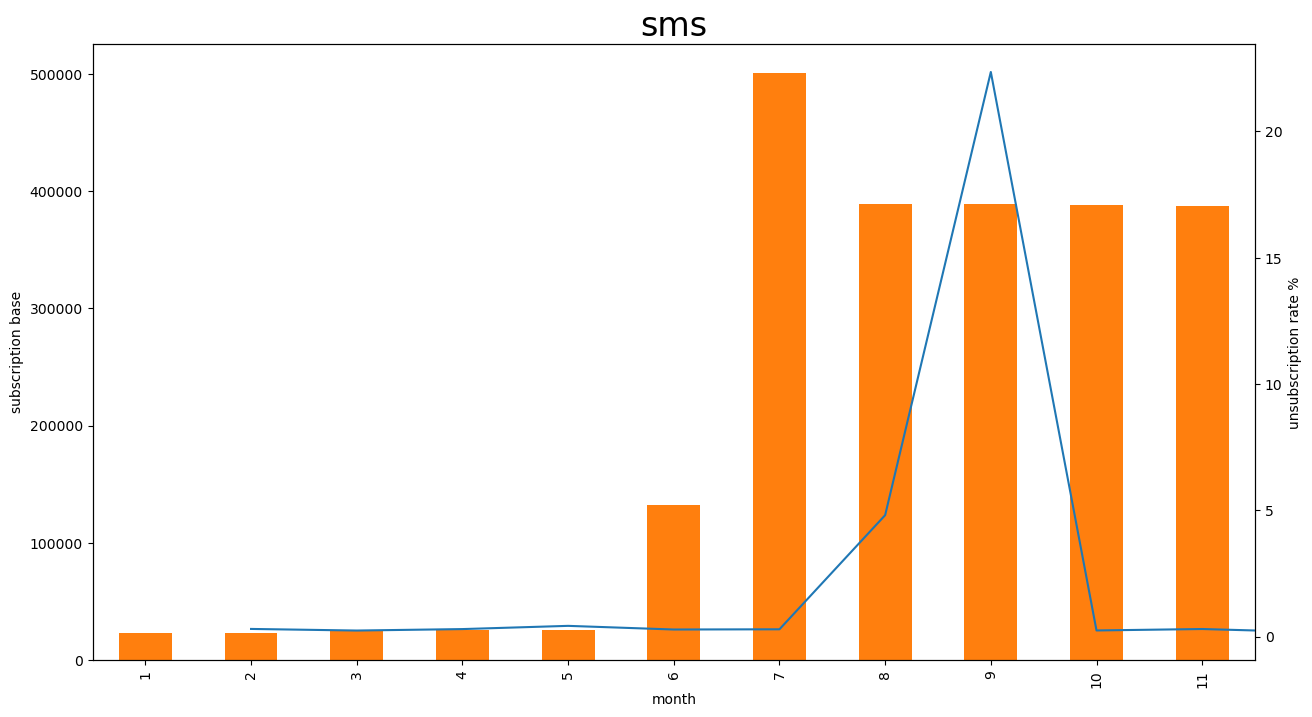

In [36]:
# use the plot function to generate visual
complot(ym_sms)
plt.title('sms', fontsize=24)
plt.show()

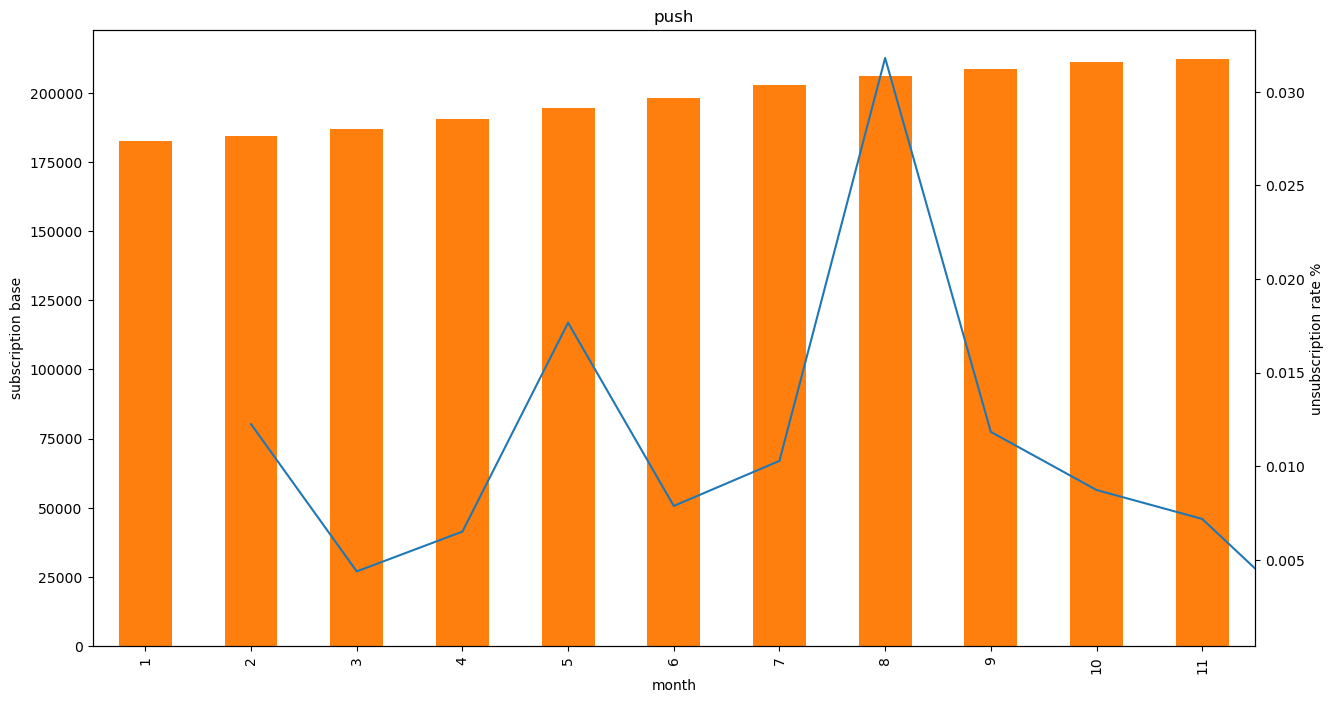

In [37]:
# Push channel
complot(ym_push)
plt.title('push')
plt.show()

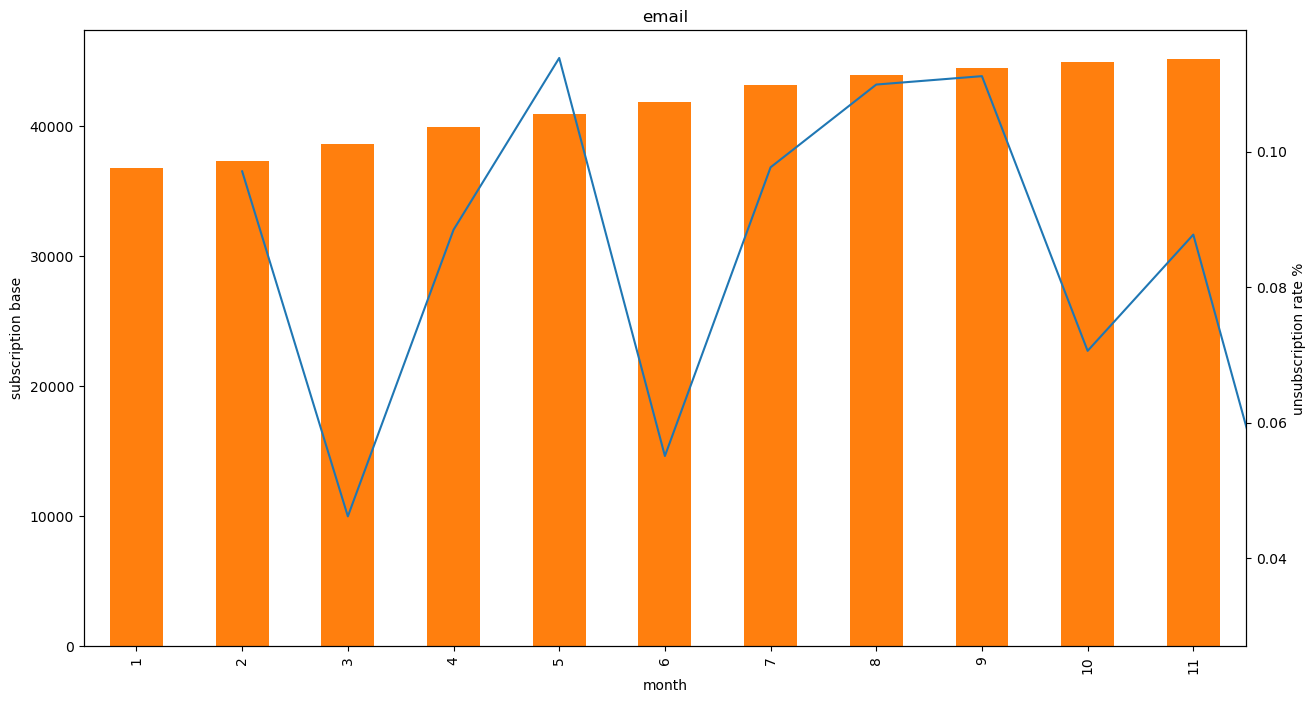

In [38]:
# Email channel
complot(ym_email)
plt.title('email')
plt.show()

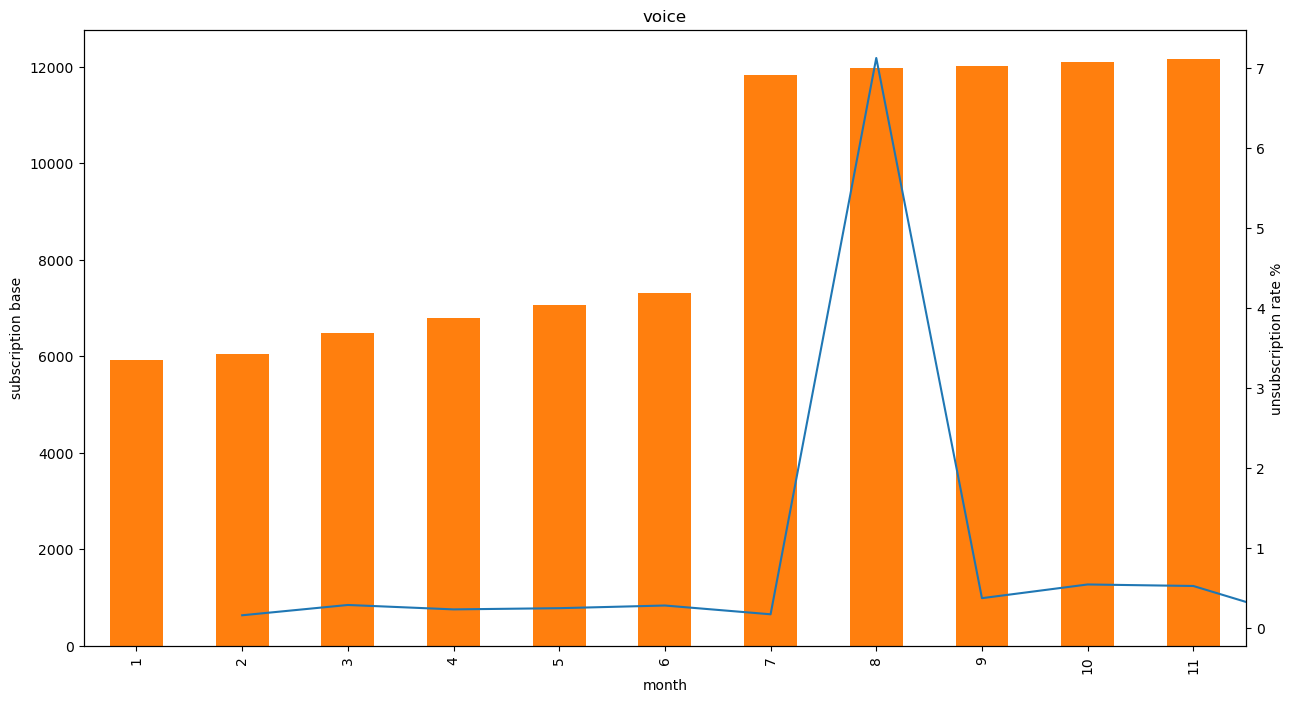

In [39]:
# Voice channel
complot(ym_voice)
plt.title('voice')
plt.show()

Brand breakdown analysis

brand kitkat
Processing SMS ...


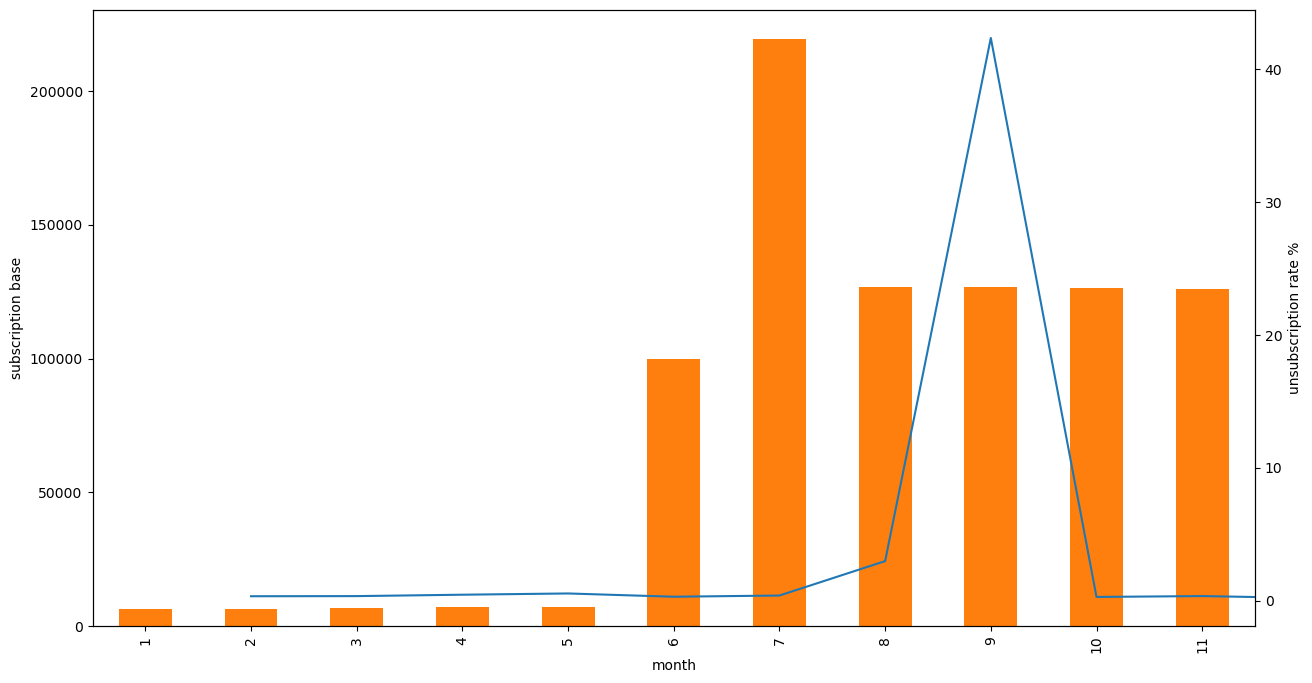

Processing EMAIL ...


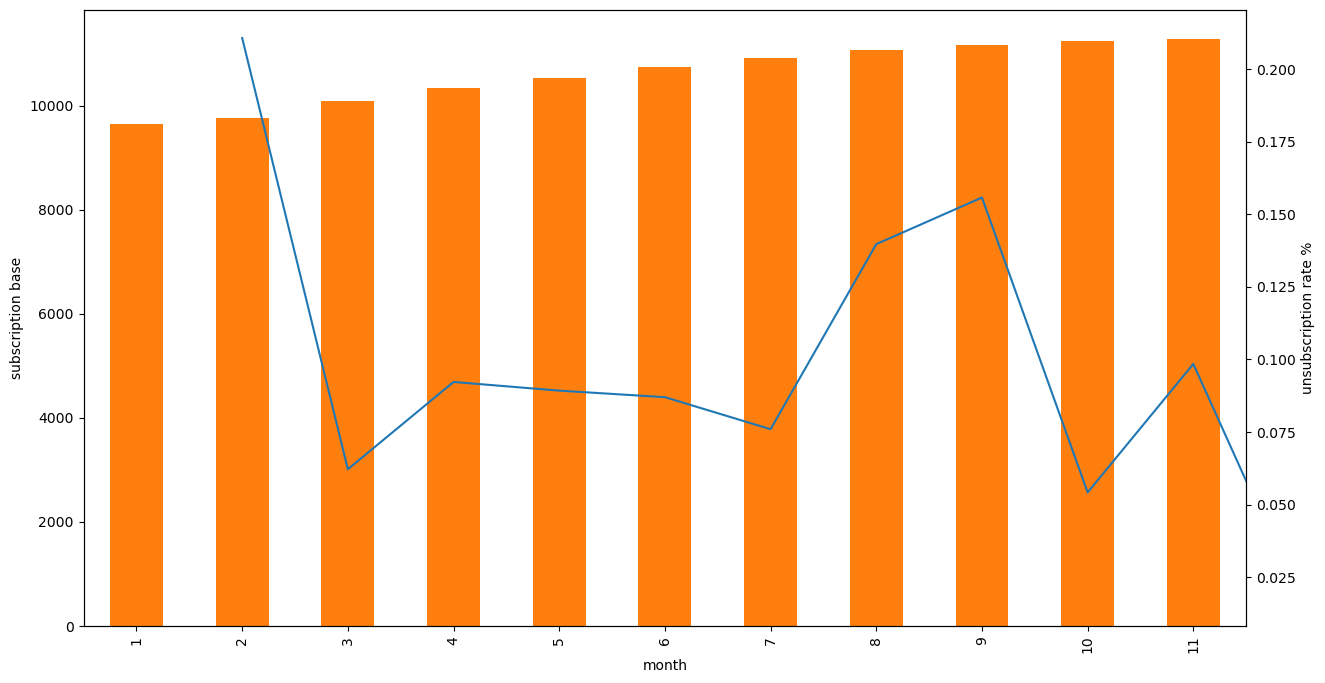

Processing VOICE ...


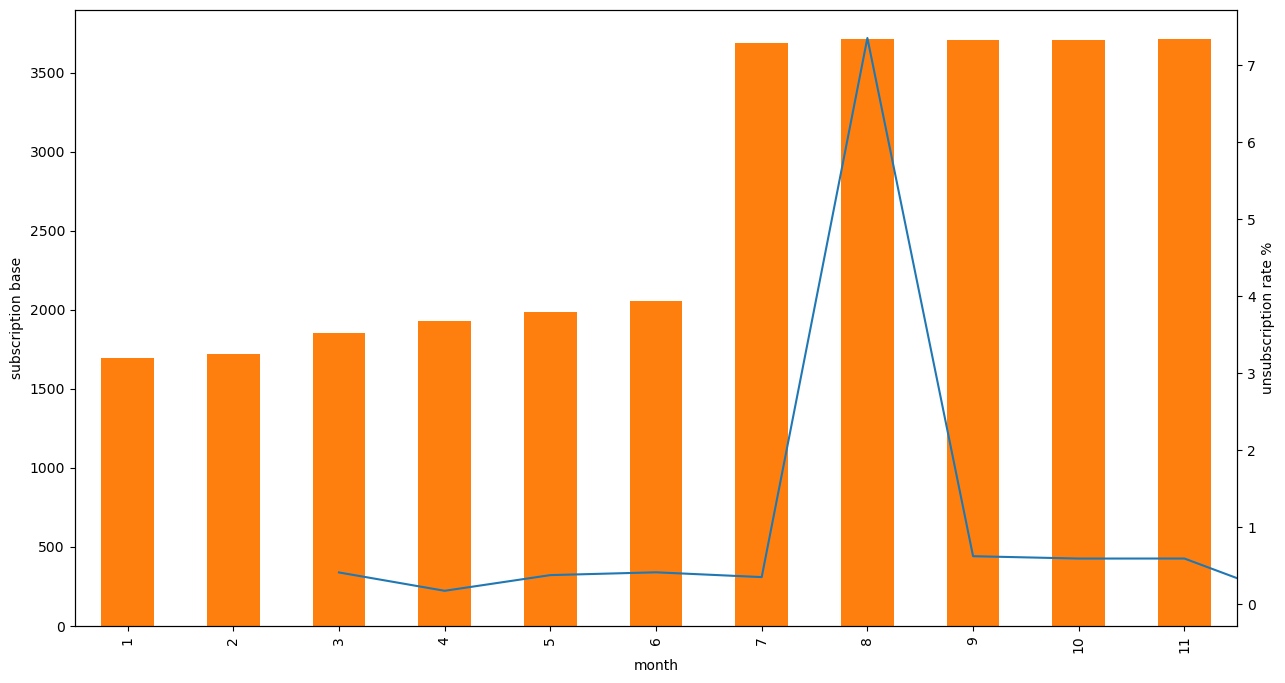

Processing PUSH ...


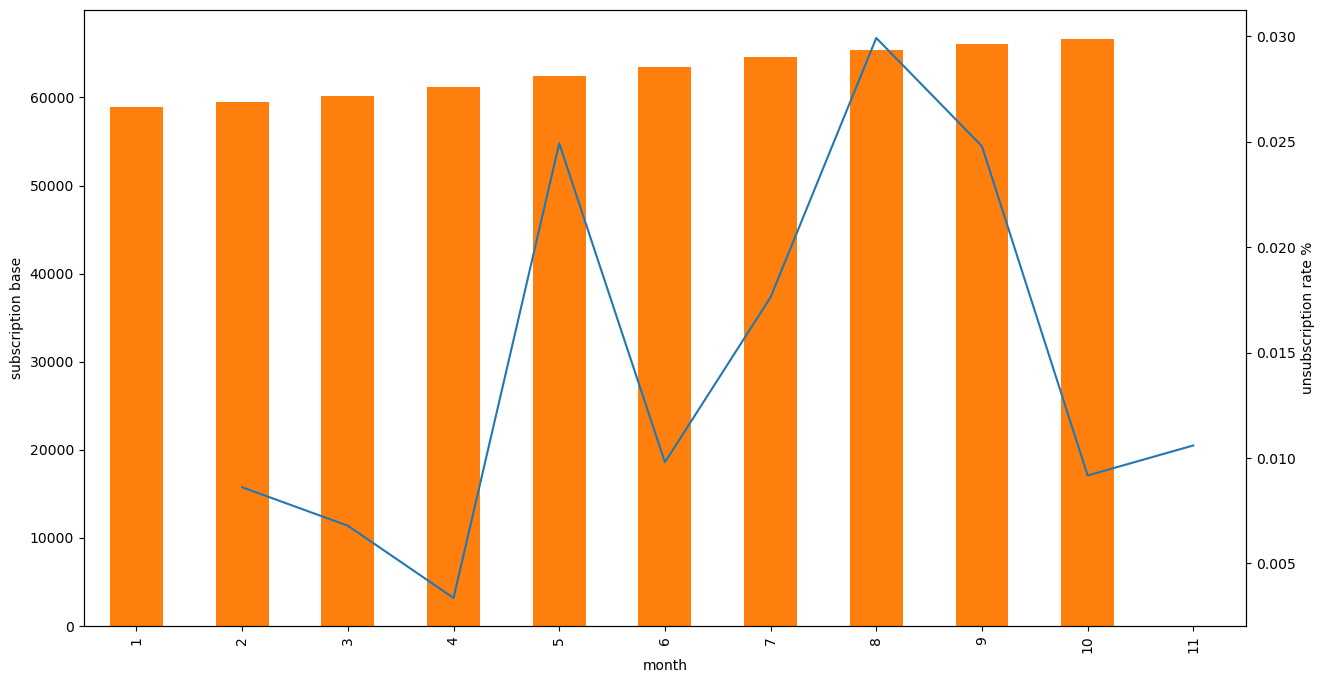

brand gerber
Processing SMS ...


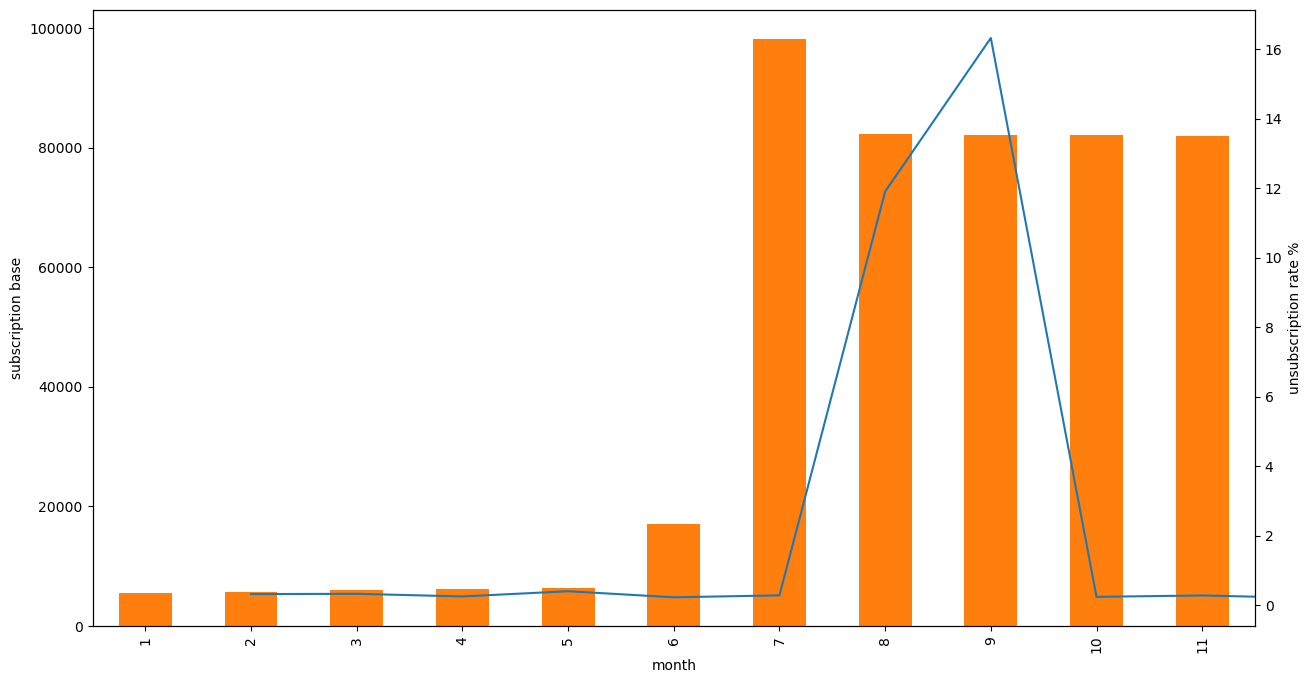

Processing EMAIL ...


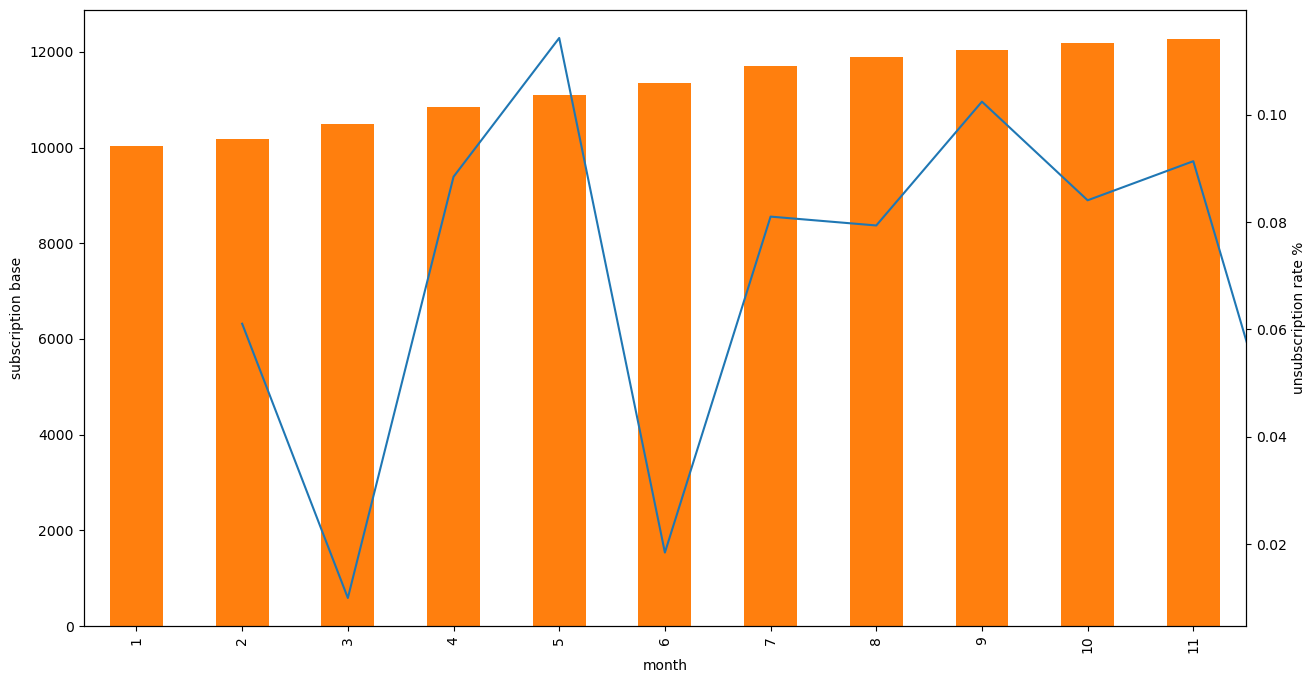

Processing VOICE ...


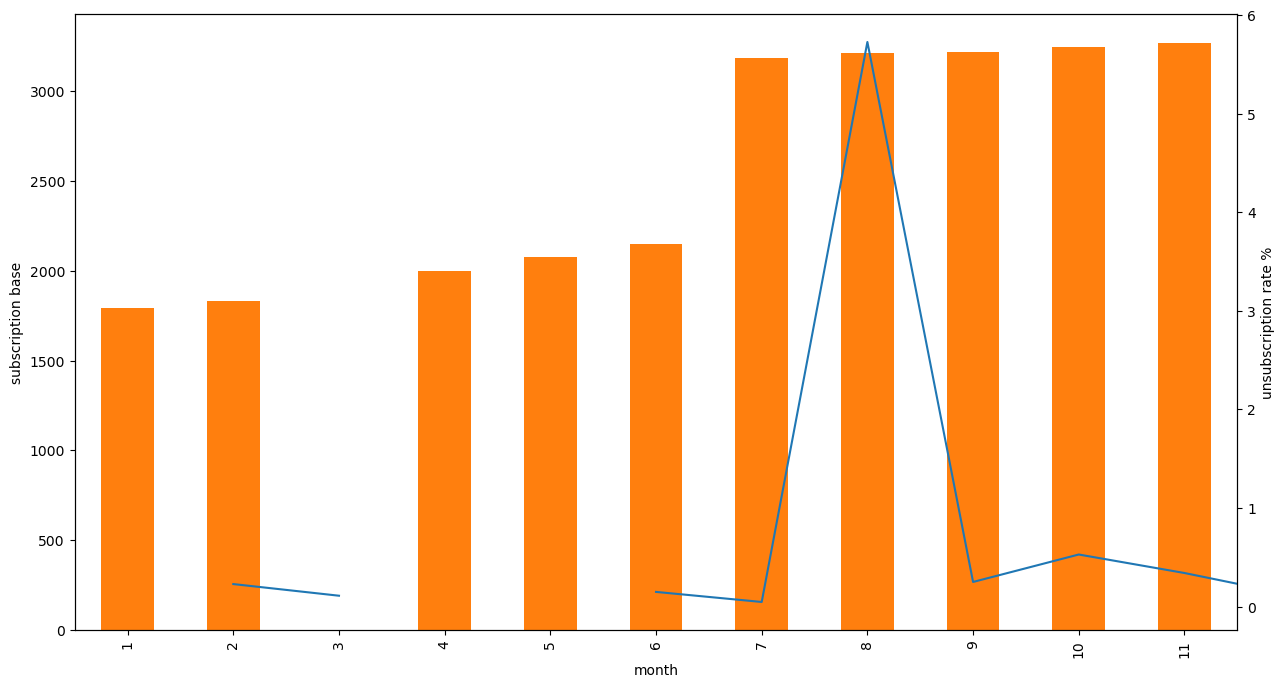

Processing PUSH ...


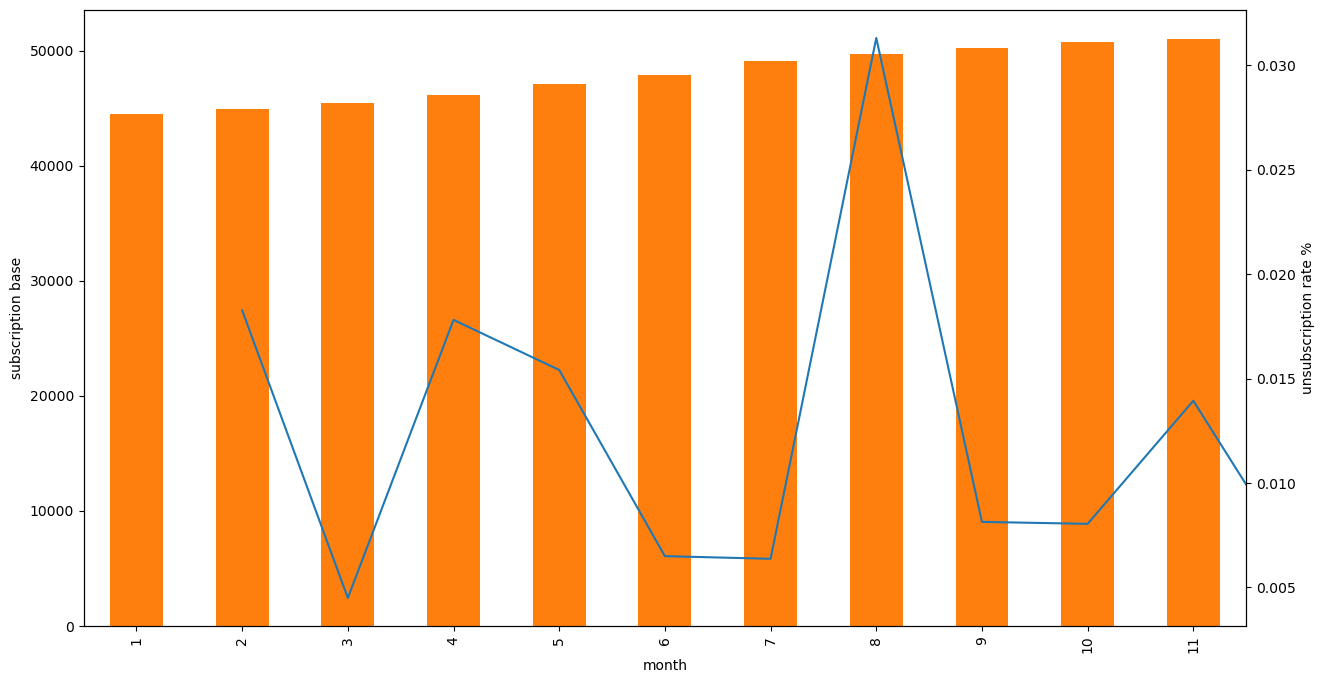

brand nescafe
Processing SMS ...


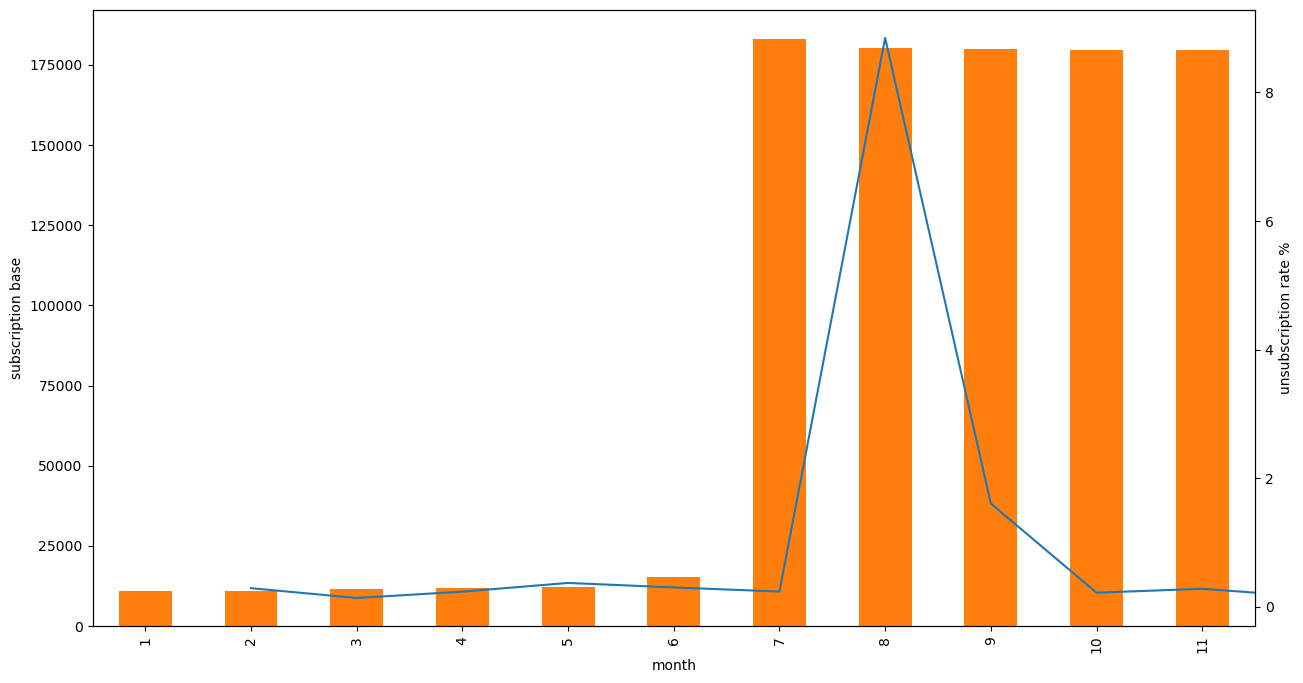

Processing EMAIL ...


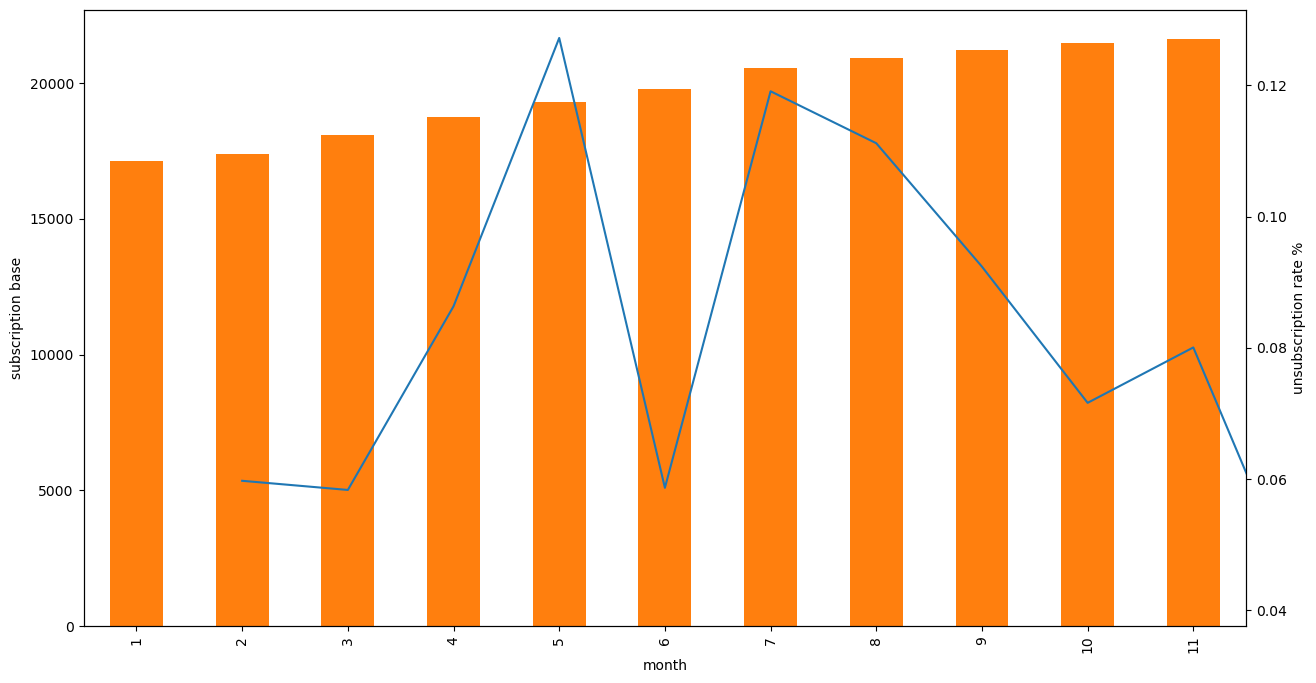

Processing VOICE ...


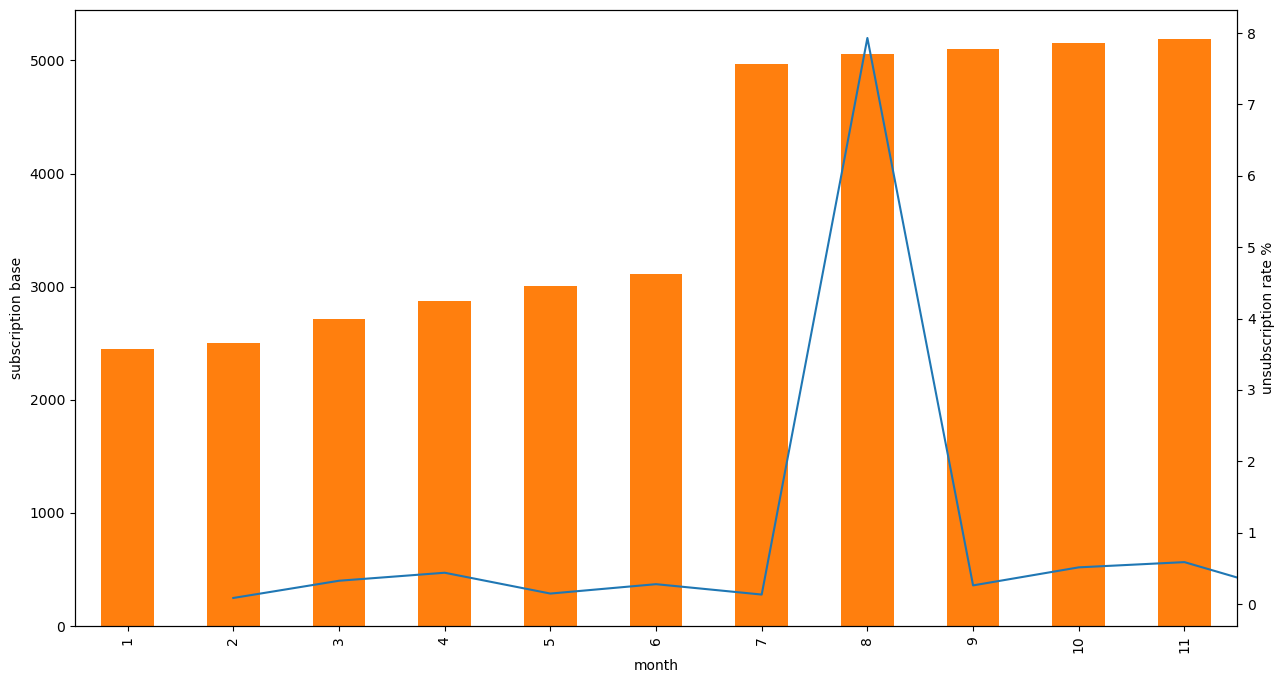

Processing PUSH ...


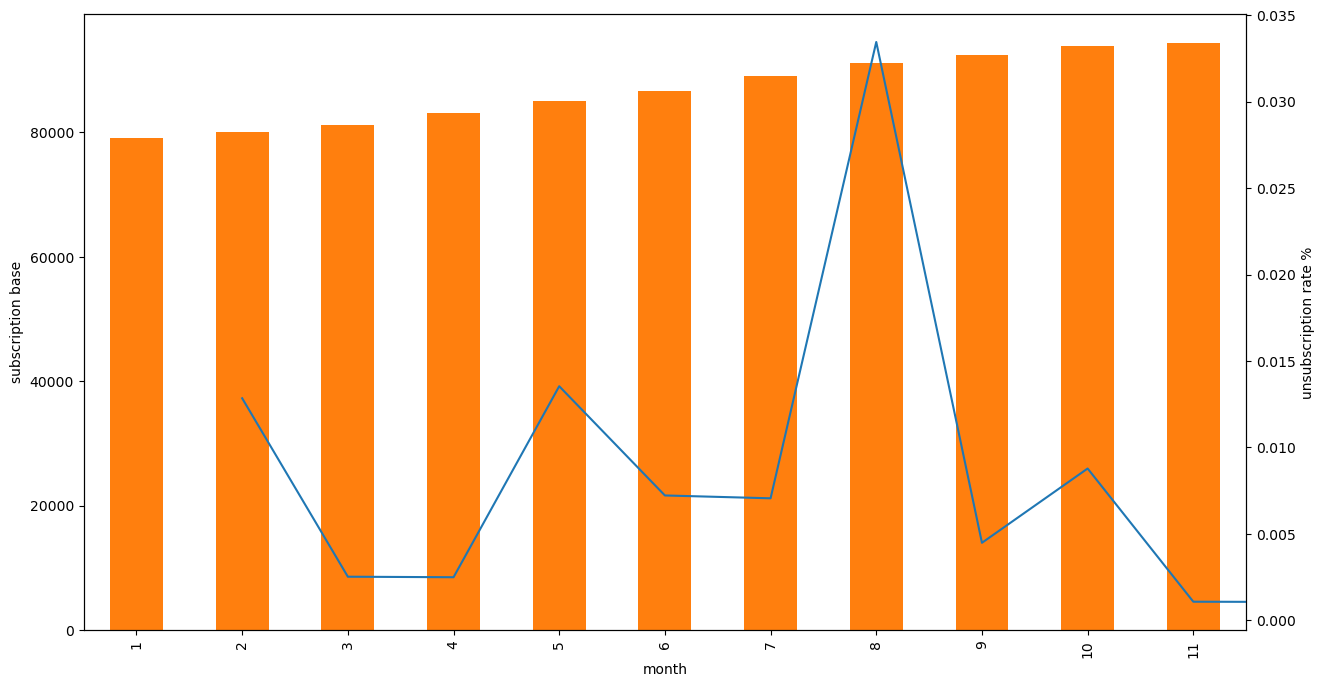

In [40]:
# for loop to run analysis for all brand at once
brand = df.brand.unique()
channel = df.channel.unique()

for brand in brand:
    print('brand {}'.format(brand))
    brand = df[df['brand'] == brand]
    for chan in channel:
        print('Processing {} ...'.format(chan))
        chan = brand[brand['channel'] == chan]
        counts = unrate(chan)
        
        complot(counts)
        plt.show()
